In [136]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [137]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [138]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(4)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [139]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    tau_1 = Paras_global[2]
    tau_2 = Paras_global[3]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 

    qml.RZ(phi_z, wires=0)
    qml.RZ(phi_z, wires=1)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

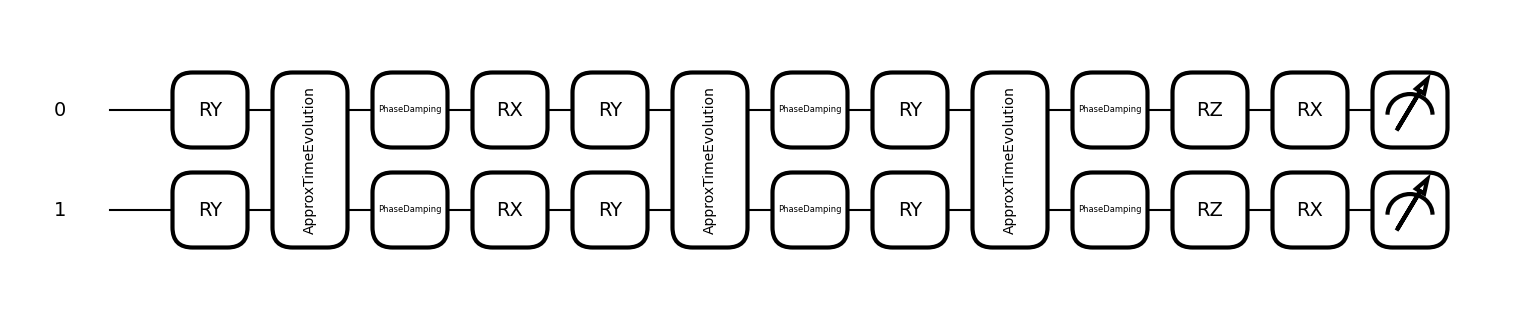

In [140]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [141]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, K) @ get_density_matrix @ pnp.kron(K, K).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K \otimes K)^{\dagger}}
% (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes K) \rho (K \otimes K)^{\dagger}]}
$$

In [142]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [143]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [144]:
def get_constraints(gamma_ps_current, tau_current):
    if gamma_ps_current == 0:
        if tau_current == 0:
            return [
                (2.35619449, 2.35619449),  
                (-float('inf'), float('inf')),  
                (-float('inf'), float('inf')), 
                (-float('inf'), float('inf'))
            ]
        elif tau_current == 0.005:
            return [
                (np.pi/2, np.pi), 
                (0, np.pi), 
                (-float('inf'), float('inf')), 
                (-float('inf'), float('inf'))
            ]
        elif tau_current == 0.05:
            return [
                (np.pi/2, np.pi), 
                (0, np.pi), 
                (-float('inf'), float('inf')), 
                (-float('inf'), float('inf'))
            ]
        elif tau_current == 0.5:
            return [
                (np.pi/2, np.pi), 
                (0.69686375, 2.39686375),  
                (np.pi/2, np.pi/2), 
                (np.pi/2, np.pi/2)
            ]
        elif tau_current == 0.1:
            return [
                (np.pi/2, np.pi), 
                (0, np.pi), 
                (-float('inf'), float('inf')), 
                (-float('inf'), float('inf'))
            ]

In [145]:
def lbfgsb(cost_function_in, initial_parameters_in, constraints_in, gradient_in):
    result = sp.optimize.minimize(
            fun = cost_function_in, 
            x0 = initial_parameters_in, 
            method = 'L-BFGS-B', 
            bounds = constraints_in, 
            jac = gradient_in,
            
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
    
    return result

In [146]:
def scipy_optimization(sweep_range_in, initial_parameters, method, gamma_ps_idx, tau_idx):
    Phi = np.arange(sweep_range_in[0], sweep_range_in[1], sweep_range_in[2])
    Data = np.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    gradient = grad(cost_function)
    hessian = jacobian(gradient)
    
    global Phi_global
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)
        
        constraints = get_constraints(gamma_ps_idx, tau_idx)
        opt_result = lbfgsb(cost_function, initial_parameters, constraints, gradient)
        
        print("CFI =", -opt_result.fun, "Paras =", opt_result.x)
        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x
        
    return Data

In [147]:
def optimization_by_tau(sweep_range_in, initia_parameters, tau_dephase, gamma_post_selection, method):
    for tau_idx, tau_current in enumerate(tau_dephase):
            set_circuit(tau_current, gamma_post_selection)

            temp = scipy_optimization(sweep_range_in, initia_parameters, method, gamma_post_selection, tau_current)
            if tau_idx == 0:
                Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
                Data[tau_idx][:, :] = temp
            else:
                Data[tau_idx][:, :] = temp

    return Data

In [148]:
# ===================
tau_set = np.array([0, 5e-3, 5e-2, 5e-1, 1e-1])
gamma_ps_set = 0
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(4)
initial_parameters[:4] = np.pi/2
# ===================
sweep_range_set = np.array([1e-2, np.pi*2, 1e-1])


res = optimization_by_tau(sweep_range_set, initial_parameters, tau_set, gamma_ps_set, 'LBFGSB')

CFI = 3.999999999607027 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.9999999999966285 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.9999999999990266 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999525 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999691 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.9999999999997655 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999801 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.9999999999998184 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999817 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.9999999999998037 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999769 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999699 Paras = [2.35619449 1.57079633 1.57079633 1.57079633]
CFI = 3.999999999999554 Paras = [2.35619449 1.57079633 1.57

In [ ]:
class Index(Enum):
    PHI = 0
    CFI = 1
    
    PARAS_START = 2
    THETA_X = 2
    PHI_Z = 3
    
    TAU_1 = 4
    TAU_2 = 5
    
def plot_result(result_data, tau_dephase, gamma_ps_select, object):
    """
    Plot the results of the optimization based on the specified object type. 
    It supports plotting Classical Fisher Information (CFI) and the optimized parameters theta_x and phi_z.

    Args:
        result_data (np.ndarray): Data from the optimization process, including Phi, CFI, and parameters.
        tau_dephase (list): List of dephasing rates tau used in the optimization.
        gamma_ps_select (float): The gamma value for post-selection used in the optimization.
        object (str): Specifies the type of plot to generate. Can be 'CFI', 'theta_x', 'phi_z', 'tau_1', or 'tau_2'.

    The function creates and displays a plot based on the specified object type. 
    For 'CFI', it plots the Classical Fisher Information over time. 
    For 'theta_x' and 'phi_z', it plots these parameters over time. 
    For 'tau_1' and 'tau_2', it plots these tau parameters over time.
    Each plot includes data for all tau dephasing rates, each represented as a separate line in the plot.
    """
    if object == 'CFI':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.CFI.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_select}$')
        plt.xlabel('Time')
        plt.ylabel('CFI')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'theta_x':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.THETA_X.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        plt.ylim(0, np.pi)

        plt.title(f'Optimized $\\theta_{{x}}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'phi_z':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.PHI_Z.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        # plt.ylim(-np.pi, 2*np.pi)

        plt.title(f'Optimized $\\phi_{{z}}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'tau_1':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.TAU_1.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        plt.ylim(0, np.pi)

        plt.title(f'Optimized $\\tau_{1}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()
        
    elif object == 'tau_2':
        for tau_idx, tau_current in enumerate(tau_dephase):
            plt.plot(
                result_data[tau_idx][:,Index.PHI.value], 
                result_data[tau_idx][:,Index.TAU_2.value], 
                label = f'$\\tau$ = {tau_current}'
            )
            
        plt.yticks(
            [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
            ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
        )
        plt.ylim(0, np.pi)

        plt.title(f'Optimized $\\tau_{2}$')
        plt.xlabel('Time')
        plt.ylabel('RAD')
        plt.grid()
        plt.legend()
        plt.show()

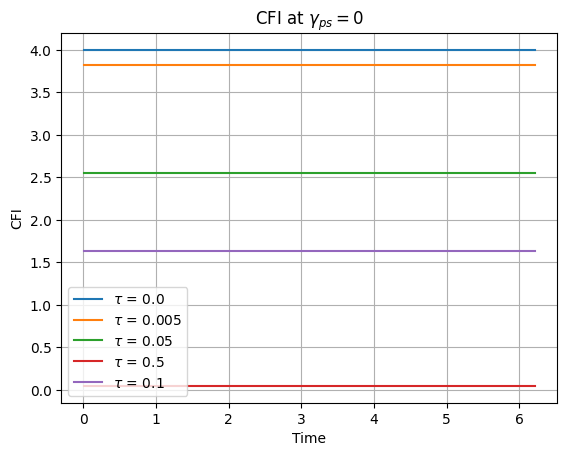

In [ ]:
plot_result(res, tau_set, gamma_ps_set, 'CFI')

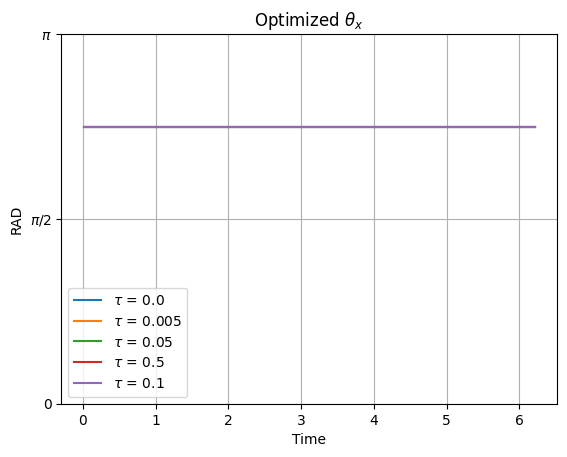

In [ ]:
plot_result(res, tau_set, gamma_ps_set, 'theta_x')

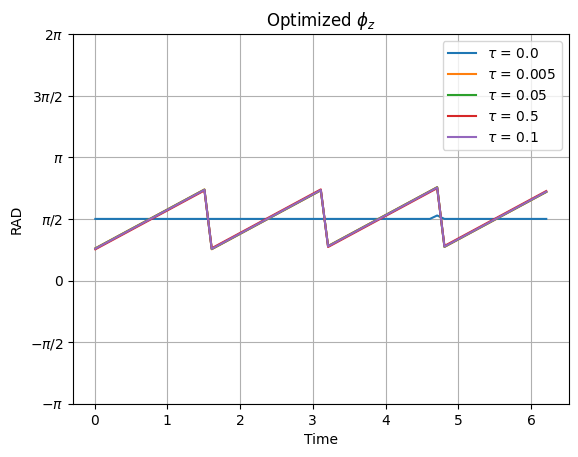

In [ ]:
plot_result(res, tau_set, gamma_ps_set, 'phi_z')

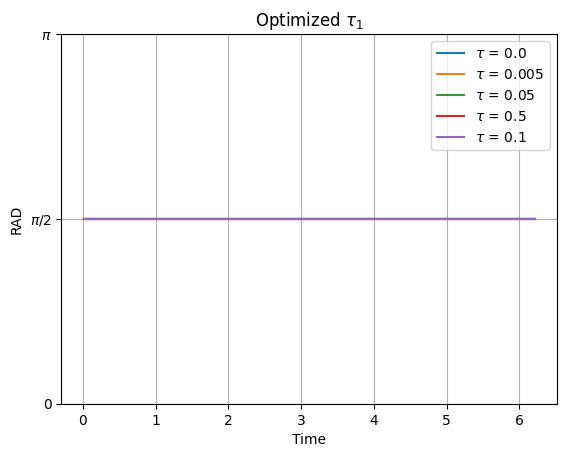

In [ ]:
plot_result(res, tau_set, gamma_ps_set, 'tau_1')

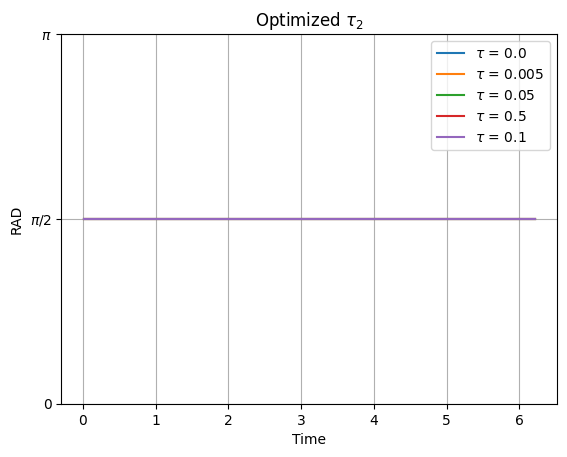

In [ ]:
plot_result(res, tau_set, gamma_ps_set, 'tau_2')